## Прогнозирование отказа моторов

Необходимо предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике.
Считаем, что максимальный цикл мотора в данных -- это последний цикл перед поломкой.
Нужно предложить варианты использования полученной модели на практике.

Доп. задание: предложить альтернативную постановку задачи прогноза отказа моторов.

**Описание данных:**

    id -- идентификатор мотора
    cycle -- цикл работы
    p00-p20 -- показания датчиков считываемые в процессе работы
    s0, s1 -- настройки изменяемые в конце каждого цикла

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

pd.set_option("display.max_rows", 250)
pd.set_option("display.max_columns", 250)
plt.rcParams['figure.figsize'] = (19, 16)
warnings.filterwarnings("ignore")

**Прочитаем данные, взглянем на начальные статистики**

In [170]:
df = pd.read_csv('data.csv')
df

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,397,2388,100,644.00,38.39,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,396,2388,100,643.81,38.34,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,397,2388,100,643.49,38.34,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,397,2388,100,643.83,38.53,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


In [171]:
df.describe()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
count,16138.000000,16138.000000,1.613800e+04,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04,16138.000000,16138.0,16138.0,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04,16138.000000,16138.000000,16138.000000,16138.000000,16138.000000,1.613800e+04
mean,40.707894,105.548147,5.186700e+02,1.300000e+00,47.544263,521.405420,2388.096737,8143.933458,8.442581,3.000000e-02,393.227104,2388.0,100.0,642.686773,38.814276,23.288552,1590.582096,1409.033729,1.462000e+01,21.609795,553.359776,2388.097368,9065.461291,0.000010,6.196555e-08
std,23.395354,65.915295,6.275708e-11,3.932532e-13,0.267422,0.738252,0.072604,19.731349,0.037520,1.230304e-14,1.549031,0.0,0.0,0.500711,0.181043,0.108606,6.129960,8.977073,3.044770e-12,0.001417,0.887947,0.071608,22.781362,0.002188,2.939096e-04
min,1.000000,1.000000,5.186700e+02,1.300000e+00,46.860000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,641.210000,38.160000,22.907100,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,-0.008600,-6.000000e-04
25%,20.000000,51.000000,5.186700e+02,1.300000e+00,47.350000,520.940000,2388.040000,8132.830000,8.415300,3.000000e-02,392.000000,2388.0,100.0,642.330000,38.700000,23.220600,1586.330000,1402.500000,1.462000e+01,21.610000,552.800000,2388.050000,9052.820000,-0.001400,-3.000000e-04
50%,42.000000,101.000000,5.186700e+02,1.300000e+00,47.520000,521.460000,2388.090000,8140.750000,8.439800,3.000000e-02,393.000000,2388.0,100.0,642.650000,38.830000,23.296300,1590.190000,1408.220000,1.462000e+01,21.610000,553.430000,2388.090000,9060.750000,0.000000,0.000000e+00
75%,61.000000,153.000000,5.186700e+02,1.300000e+00,47.710000,521.940000,2388.140000,8148.817500,8.466000,3.000000e-02,394.000000,2388.0,100.0,643.010000,38.940000,23.365600,1594.450000,1414.650000,1.462000e+01,21.610000,554.000000,2388.140000,9069.940000,0.001500,3.000000e-04
max,80.000000,362.000000,5.186700e+02,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,399.000000,2388.0,100.0,644.530000,39.430000,23.612700,1614.930000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,0.008700,6.000000e-04


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
id       16138 non-null int64
cycle    16138 non-null int64
p00      16138 non-null float64
p01      16138 non-null float64
p02      16138 non-null float64
p03      16138 non-null float64
p04      16138 non-null float64
p05      16138 non-null float64
p06      16138 non-null float64
p07      16138 non-null float64
p08      16138 non-null int64
p09      16138 non-null int64
p10      16138 non-null int64
p11      16138 non-null float64
p12      16138 non-null float64
p13      16138 non-null float64
p14      16138 non-null float64
p15      16138 non-null float64
p16      16138 non-null float64
p17      16138 non-null float64
p18      16138 non-null float64
p19      16138 non-null float64
p20      16138 non-null float64
s1       16138 non-null float64
s2       16138 non-null float64
dtypes: float64(20), int64(5)
memory usage: 3.1 MB


**Посмотрим на количество уникальных значений признаков, карту взаимных корреляций, а далее сделаем первичный отбор признаков**

In [173]:
for column in df:
    print(column, df[column].nunique())

id 80
cycle 362
p00 1
p01 1
p02 156
p03 418
p04 56
p05 5707
p06 1871
p07 1
p08 12
p09 1
p10 1
p11 307
p12 116
p13 4518
p14 2899
p15 3865
p16 1
p17 2
p18 502
p19 53
p20 5955
s1 155
s2 13


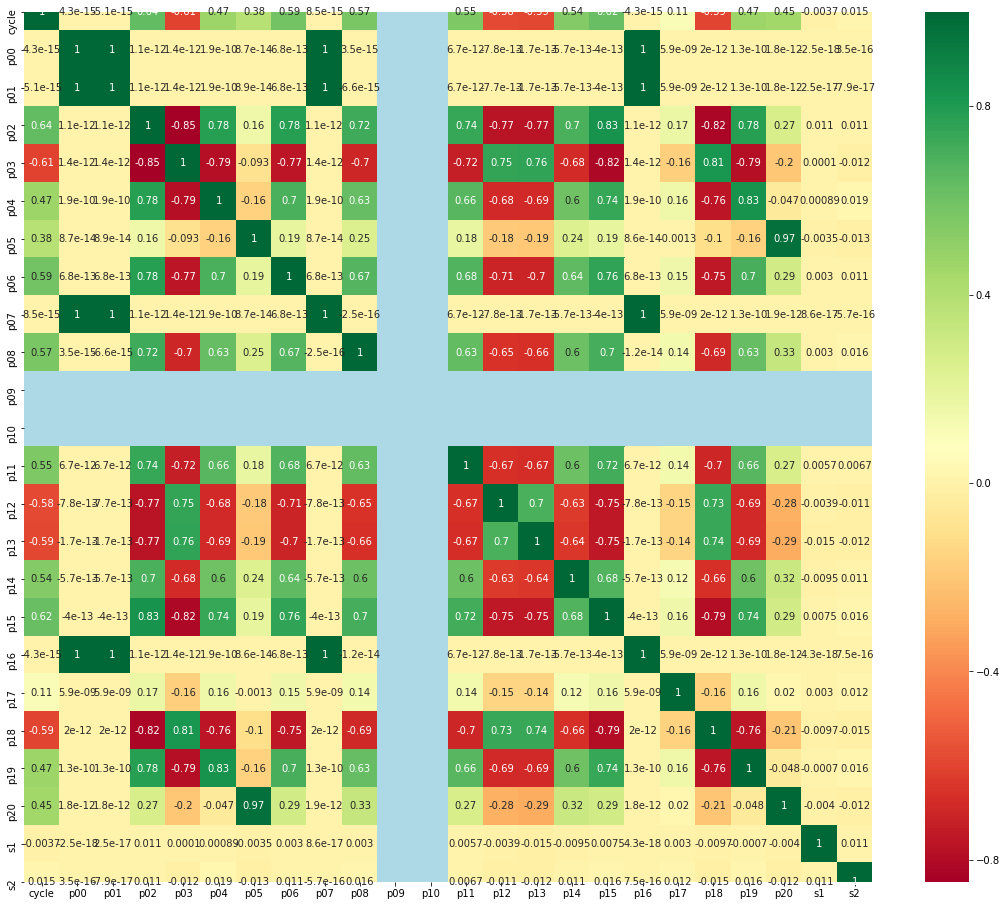

In [174]:
corr = df.iloc[:, 1:].corr()

color = plt.get_cmap('RdYlGn')
color.set_bad('lightblue')

sns.heatmap(corr, annot=True, cmap=color)

**По карте корреляций видим, что признаки p00, p01, p05, p07, p09, p10, p16 не несут математического смысла для модели из-за сильной скоррелированности с другими признаками или константности, поэтому мы их убираем и дальше работаем без них**

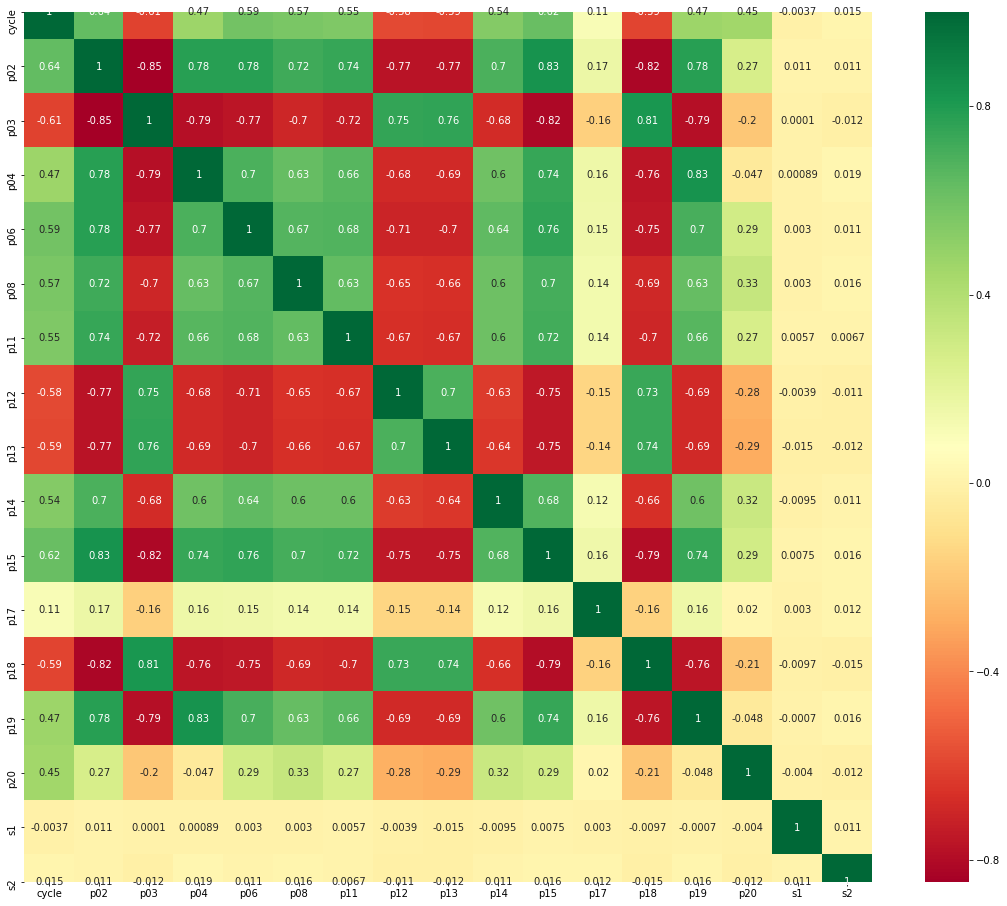

In [175]:
mot = df.drop(labels=['p00', 'p01', 'p05', 'p07', 'p09', 'p10', 'p16'], axis=1)

sns.heatmap(mot.iloc[:, 1:].corr(), annot=True, cmap=color)

In [176]:
mot

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,48.41,520.06,2388.12,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,48.04,519.67,2388.21,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,48.04,519.72,2388.20,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,21.61,551.78,2388.17,9164.10,-0.0024,0.0002


**Создадим фичу "max_cycles" обозначающую максимальный срок жизни каждого мотора до поломки**

In [177]:
max_cycles = mot.groupby('id').agg({'cycle': 'max'}).reset_index().rename(columns={'cycle': 'max_cycles'})
max_cycles

,id,max_cycles
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
5,6,188
6,7,259
7,8,150
8,9,201
9,10,222


In [178]:
mot_max = mot.merge(max_cycles, left_on='id', right_on='id')
mot_max.head()

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,max_cycles
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004,192
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,9044.07,0.0019,-0.0003,192
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,9052.94,-0.0043,0.0003,192
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,9049.48,0.0007,0.0000,192
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002,192


**Распределение максимального количества циклов до поломки по объектам**

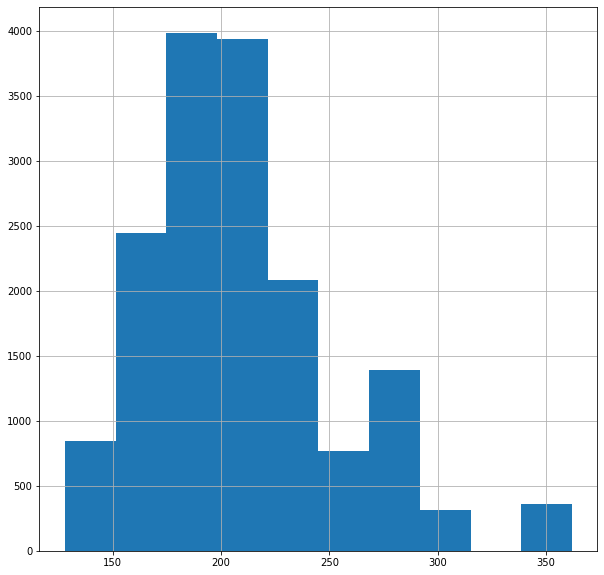

In [179]:
plt.figure(figsize=(10,10))
mot_max.max_cycles.hist()

**Для того, чтобы модель могла быть устойчивой к изменениям в признаках, проведем небольшой препроцессинг в виде нормализации**

**Лист фич для скейлера**

In [180]:
features = list(mot_max)[2:-1]
features

['p02',
 'p03',
 'p04',
 'p06',
 'p08',
 'p11',
 'p12',
 'p13',
 'p14',
 'p15',
 'p17',
 'p18',
 'p19',
 'p20',
 's1',
 's2']

**Скейлим фичи**

In [181]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mot_max[features])
mot_max_scaled = mot_max.copy()
mot_max_scaled.head()

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,max_cycles
0,1,1,47.47,521.66,2388.02,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004,192
1,1,2,47.49,522.28,2388.07,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,9044.07,0.0019,-0.0003,192
2,1,3,47.27,522.42,2388.03,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,9052.94,-0.0043,0.0003,192
3,1,4,47.13,522.86,2388.08,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,9049.48,0.0007,0.0000,192
4,1,5,47.28,522.19,2388.04,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002,192


In [182]:
mot_max_scaled[features] = scaled_features

**Наш новый стандартизированный датасет с экстра фичой, которую сделаем таргетом**

In [183]:
mot_max_scaled

,id,cycle,p02,p03,p04,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,p20,s1,s2,max_cycles
0,1,1,-0.277709,0.344853,-1.056961,-0.615179,-0.792200,-1.731137,1.357314,1.201158,-0.143904,-0.939503,0.144707,1.126481,-0.521854,-0.845950,-0.324474,-1.361216,192
1,1,2,-0.202919,1.184700,-0.368269,-0.287340,-0.792200,-1.072054,1.025890,1.243515,0.201949,-0.656552,0.144707,0.439482,-0.801162,-0.939011,0.863760,-1.020965,192
2,1,3,-1.025615,1.374343,-0.919222,-0.660490,-2.083370,-0.672610,0.749704,0.512406,-0.422870,-0.538469,0.144707,1.013858,-0.242547,-0.549646,-1.969722,1.020543,192
3,1,4,-1.549148,1.970364,-0.230531,-1.982506,-0.792200,-0.672610,0.363043,0.785881,-1.271189,-0.798027,0.144707,1.227841,0.176415,-0.701529,0.315344,-0.000211,192
4,1,5,-0.988219,1.062787,-0.781484,-0.351309,-0.146615,-0.632665,0.473518,1.066722,-1.261401,-0.313445,0.144707,0.721038,-0.521854,-0.452634,-0.872890,-0.680713,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,2.339959,-1.307750,1.009113,2.047510,2.435725,2.622805,-2.343582,-1.111872,2.231389,2.215297,0.144707,-1.261123,1.433300,3.518718,1.914891,0.680292,185
16134,80,182,3.237446,-1.822495,0.320422,2.844452,1.790140,2.243333,-2.619768,-2.526208,1.262348,1.924548,0.144707,-1.981908,0.874684,4.160052,-0.644384,1.360794,185
16135,80,183,1.853821,-2.350786,1.560066,1.812959,2.435725,1.604223,-2.619768,-3.267446,2.086196,2.814621,0.144707,-1.779187,0.316069,3.835654,0.818059,-0.000211,185
16136,80,184,1.853821,-2.283057,1.422328,1.485121,2.435725,2.283278,-1.570260,-2.683664,2.027467,2.361229,0.144707,-1.779187,1.014338,4.329933,-1.101397,0.680292,185


**Беремся за модели**

In [184]:
X = mot_max_scaled[features].to_numpy()
y = mot_max_scaled['max_cycles'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

**Elastic Net CV**

In [185]:
elastic_net_cv = ElasticNetCV(cv=5, random_state=42)
elastic_net_cv.fit(X_train, y_train)
y_pred = elastic_net_cv.predict(X_test)
print('ElasticNetCV MAE:',mean_absolute_error(y_test, y_pred))
print('ElasticNetCV MSE:',mean_squared_error(y_test, y_pred))

ElasticNetCV MAE: 32.620889744292775
ElasticNetCV MSE: 1844.0421768056337


**Grid Search Elastic Net**

In [186]:
elastic_net = ElasticNet(random_state=42)

param_grid = {
    'max_iter': [500, 1500, 3000, 5000],
    'alpha': [0, 0.5, 0.1, 0.01, 0.001],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

grid = GridSearchCV(elastic_net, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [187]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=42, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 0.5, 0.1, 0.01, 0.001],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'max_iter': [500, 1500, 3000, 5000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [190]:
y_pred = grid.best_estimator_.predict(X_test)
print('Grid Search Elastic Net MAE:', mean_absolute_error(y_test, y_pred))
print('Grid Search Elastic Net MSE:', mean_squared_error(y_test, y_pred))

Grid Search Elastic Net MAE: 32.62054225233905
Grid Search Elastic Net MSE: 1843.2940445600675


**Grid Search Random Forest Regressor**

In [200]:
rf = RandomForestRegressor(random_state=42)

random_grid = {'n_estimators': [100, 300],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, None],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 3],
               'bootstrap': [True, False]}

rf_grid = GridSearchCV(rf, random_grid, cv=3, verbose=10, n_jobs=-1)

In [201]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [203]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [202]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print('Grid Search Elastic Net MAE:', mean_absolute_error(y_test, y_pred))
print('Grid Search Elastic Net MSE:', mean_squared_error(y_test, y_pred))

Grid Search Elastic Net MAE: 32.29618424104745
Grid Search Elastic Net MSE: 1775.9404420554768


## Использование на практике

**Допустим, есть какая-то сырьевая компания, которая хочет сэкономить на поломках оборудования и предиктивно делать техобслуживание не дожидаясь остановки**